# Data Science Challenge
-----------------------

## [ Part. 2 ] Model Training

## 1. Train / Test Split

## 2. Feature Selection by DecisionTree

## 3. 

In [128]:
%load_ext autoreload
%autoreload 2

In [129]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from source.utils import plot_precision_recall_curve

pd.options.display.max_columns = 50

%matplotlib inline

Load feature engineered data

In [100]:
data = pd.read_parquet('./data/events.parquet')

#### Set target values as binary 


In [101]:
data['event_type'] = data['event_type'].map({'search':0,'book':1})

#### Encode 'origin' and 'destination' as numerical categories

In [102]:
origin_dic = {}
for idx, item in enumerate(data['origin'].unique()):
    origin_dic[item] = idx
destin_dic = {}
for idx, item in enumerate(data['destination'].unique()):
    destin_dic[item] = idx
data['origin'] = data['origin'].map(origin_dic)
data['destination'] = data['destination'].map(destin_dic)

#### Change the category value type

In [103]:
category_columns=['origin', 'destination', 'ts_dow', 'date_from_dow', 'date_to_dow']
for col in category_columns:
    data[col] = data[col].astype('category')

## 1. Train / Test Split

In [139]:
data['event_type'].value_counts()

0    45177
1     1808
Name: event_type, dtype: int64

In [104]:
book_userid = data[data['event_type']==1]['user_id'].unique()
search_userid = set(data['user_id'].unique())-set(book_userid)

In [131]:
print (len(book_userid), len(search_userid))

1804 29361


In [105]:
book_data = data[data['user_id'].isin(book_userid)]
search_data = data[data['user_id'].isin(search_userid)]
book_data.shape, search_data.shape

((9486, 20), (37499, 20))

In [ ]:
##### [ Comments ] 
There is 2 columns with NaN. <br>
It seems like NaN data is relatively small compared to the size of the entire data. <br>
22 / 47007 , 3 / 47007 

In [106]:
book_data['event_type'].value_counts()

0    7678
1    1808
Name: event_type, dtype: int64

In [107]:
sample_search_data = search_data.sample(7500)

In [108]:
sample_data = pd.concat([book_data, sample_search_data])
sample_data.shape

(16986, 20)

In [109]:
sample_data.head(2)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,act_count,diff_ts,ts_dow,date_from_dow,date_to_dow,hours_ts,ts_day,date_from_day,date_to_day,trip_duration,trip_distance
40,2017-04-24 02:20:28,0,0035d4,2018-02-08,2018-02-20,9,24,2,0,1,0.000000,0,3,1,2,24,8,20,12,1346.620137
41,2017-04-24 02:29:04,0,0035d4,2018-02-08,2018-02-20,9,24,2,0,2,6.248043,0,3,1,2,24,8,20,12,1346.620137


In [59]:
select_features = ['origin', 'destination','num_adults', 'num_children', 
                  'act_count', 'diff_ts','ts_dow', 'date_from_dow', 
                  'date_to_dow', 'hours_ts', 'ts_day','date_from_day', 
                  'date_to_day', 'trip_duration', 'trip_distance']
target_features = ['event_type']

In [90]:

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import average_precision_score


In [110]:
df = sample_data[select_features+target_features]

In [133]:
target='event_type'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size = 0.2, random_state=42)

#clf = DecisionTreeClassifier(random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_

features=features.sort_values(by='importance', ascending=False)
    

In [134]:
clf.score(X_train, y_train)

1.0

In [135]:
clf.score(X_test, y_test)

0.8990582695703355

In [136]:
y_score = clf.predict(X_test)

In [120]:
np.average(1-y_test)

0.8934667451442024

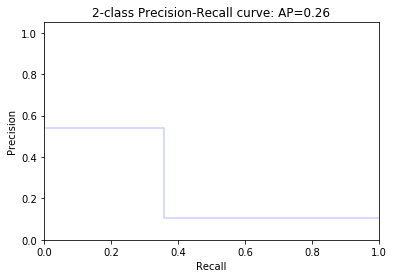

In [137]:
plot_precision_recall_curve(y_test, y_score)

In [138]:
features

,feature,importance
5,diff_ts,0.285777
4,act_count,0.224538
14,trip_distance,0.065994
1,destination,0.056322
12,date_to_day,0.046389
11,date_from_day,0.046063
9,hours_ts,0.045526
0,origin,0.045449
13,trip_duration,0.039342
10,ts_day,0.035824


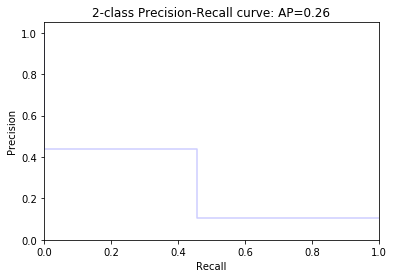

In [130]:
plot_precision_recall_curve(y_test, y_score)

In [88]:
X_test.head(2)

,origin,destination,num_adults,num_children,act_count,diff_ts,ts_dow,date_from_dow,date_to_dow,hours_ts,ts_day,date_from_day,date_to_day,trip_duration,trip_distance
13556,1,2,1,0,1,0.000000,6,1,4,13,23,27,30,3,829.647338
2471,0,77,1,0,2,5.023881,4,6,6,17,28,10,24,14,2253.463728


In [121]:
features

,feature,importance
5,diff_ts,0.306656
4,act_count,0.234950
14,trip_distance,0.069646
1,destination,0.057612
0,origin,0.046724
13,trip_duration,0.045613
11,date_from_day,0.042009
9,hours_ts,0.037185
12,date_to_day,0.032238
10,ts_day,0.031921
